In [1]:
from lib.ekyn import get_ekyn_ids,load_ekyn_pt
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader,ConcatDataset
import math
from torch import nn
from lib.models import RegNet
from torch.nn.functional import relu
import matplotlib.pyplot as plt
import torch
from lib.datasets import EpochedDataset,EpochedDatasetAnimalIdentifier
from tqdm import tqdm

CONFIG = {
    'WINDOW_SIZE':5000,
    'BATCH_SIZE':512,
    'LEARNING_RATE':1e-2,
    'DEVICE':'cuda',
}

idx = get_ekyn_ids()
train_idx,test_idx = idx,idx

In [2]:
trainloader = DataLoader(ConcatDataset([EpochedDatasetAnimalIdentifier(idx=idx,condition=condition) for idx in range(16) for condition in ['Vehicle']]),batch_size=128,shuffle=True)
devloader = DataLoader(ConcatDataset([EpochedDatasetAnimalIdentifier(idx=idx,condition=condition) for idx in range(16) for condition in ['PF']]),batch_size=128,shuffle=True)

In [3]:
model = RegNet(in_features=5000,in_channels=1,depthi=[2],widthi=[4],n_classes=16)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(),lr=CONFIG['LEARNING_RATE'],weight_decay=1e-2)

In [4]:
model.to(CONFIG['DEVICE']);
criterion.to(CONFIG['DEVICE']);

In [12]:
lossi = []
devlossi = []

In [19]:
from lib.utils import development_loop
for i in range(10):
    for j,(Xi,yi) in enumerate(tqdm(trainloader)):
        Xi,yi = Xi.to(CONFIG['DEVICE']),yi.to(CONFIG['DEVICE'])
        logits = model(Xi)
        loss = criterion(logits,yi)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        lossi.append(loss.item())
    loss,f1 = development_loop(model,devloader,criterion,CONFIG['DEVICE'])
    devlossi.append(loss)
    plt.plot(lossi)
    plt.plot(range(1080,len(lossi) + 1,len(trainloader)),devlossi)
    plt.savefig('loss.jpg')
    plt.close()
loss

 79%|███████▉  | 855/1080 [00:04<00:01, 173.64it/s] 

100%|██████████| 1080/1080 [00:04<00:00, 238.36it/s]


              precision    recall  f1-score   support

         0.0       0.20      0.21      0.20      8640
         1.0       0.34      0.56      0.42      8640
         2.0       0.56      0.92      0.70      8640
         3.0       0.70      0.39      0.50      8640
         4.0       0.22      0.03      0.06      8640
         5.0       0.23      0.59      0.33      8640
         6.0       0.43      0.29      0.34      8640
         7.0       0.33      0.12      0.18      8640
         8.0       0.71      0.58      0.64      8640
         9.0       0.29      0.42      0.34      8640
        10.0       0.34      0.12      0.18      8640
        11.0       0.25      0.31      0.27      8640
        12.0       0.62      0.34      0.44      8640
        13.0       0.44      0.41      0.42      8640
        14.0       0.31      0.07      0.12      8640
        15.0       0.30      0.50      0.37      8640

    accuracy                           0.37    138240
   macro avg       0.39   

100%|██████████| 1080/1080 [00:04<00:00, 243.88it/s]


              precision    recall  f1-score   support

         0.0       0.20      0.22      0.21      8640
         1.0       0.26      0.50      0.35      8640
         2.0       0.39      0.91      0.54      8640
         3.0       0.67      0.31      0.42      8640
         4.0       0.00      0.00      0.00      8640
         5.0       0.28      0.60      0.38      8640
         6.0       0.32      0.31      0.32      8640
         7.0       0.31      0.07      0.11      8640
         8.0       0.47      0.11      0.18      8640
         9.0       0.26      0.37      0.31      8640
        10.0       0.27      0.13      0.18      8640
        11.0       0.12      0.17      0.14      8640
        12.0       0.47      0.17      0.25      8640
        13.0       0.36      0.42      0.39      8640
        14.0       0.27      0.07      0.11      8640
        15.0       0.29      0.40      0.34      8640

    accuracy                           0.30    138240
   macro avg       0.31   

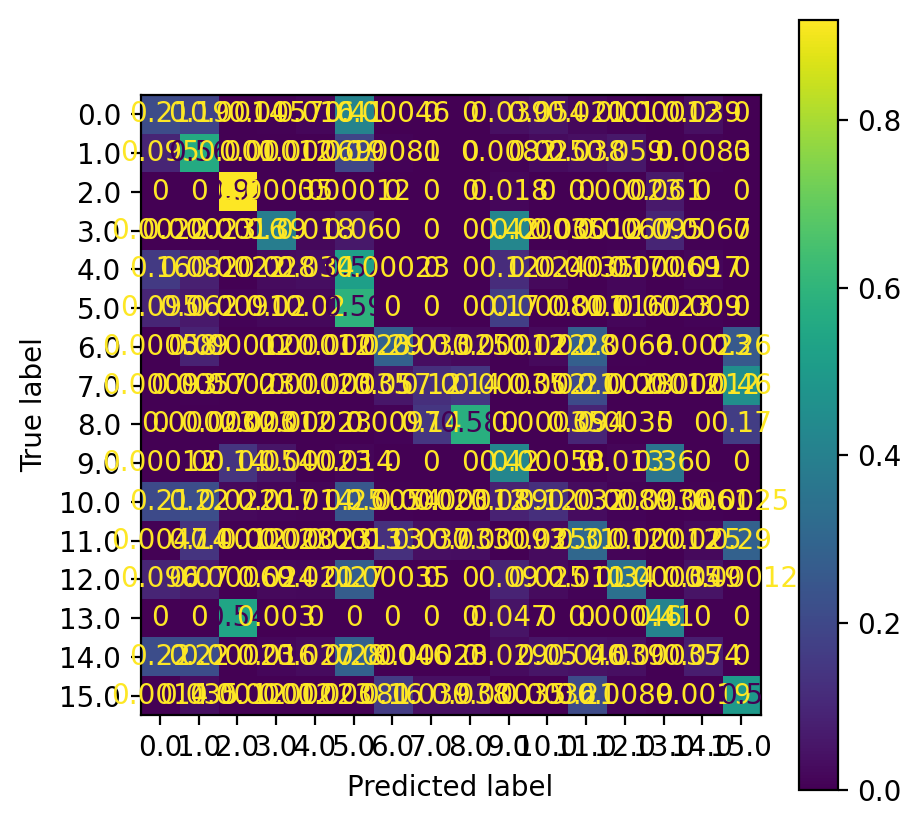

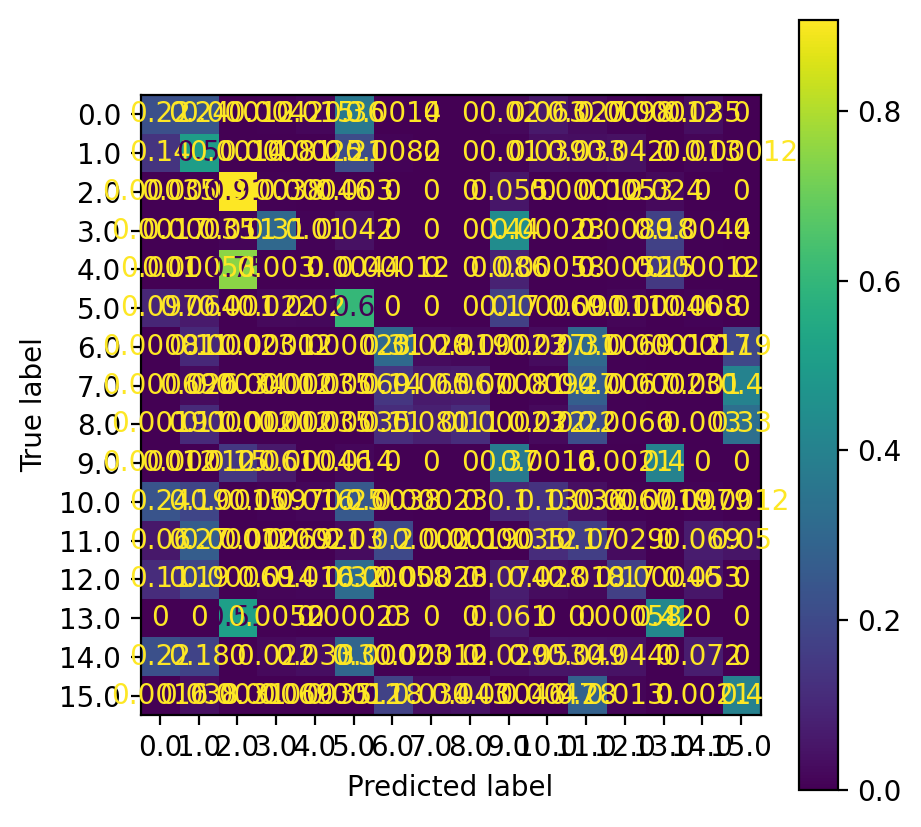

In [11]:
from lib.utils import evaluate
from sklearn.metrics import ConfusionMatrixDisplay,classification_report

loss,report,y_true,y_pred,y_logits = evaluate(dataloader=trainloader,model=model,criterion=criterion,DEVICE=CONFIG['DEVICE'])
plt.figure(figsize=(5,5),dpi=200)
ConfusionMatrixDisplay.from_predictions(y_true,y_pred,normalize='true',ax=plt.gca())
print(classification_report(y_true,y_pred))
print(loss)

loss,report,y_true,y_pred,y_logits = evaluate(dataloader=devloader,model=model,criterion=criterion,DEVICE=CONFIG['DEVICE'])
plt.figure(figsize=(5,5),dpi=200)
ConfusionMatrixDisplay.from_predictions(y_true,y_pred,normalize='true',ax=plt.gca())
print(classification_report(y_true,y_pred))
print(loss)
# loss,report,y_true,y_pred,y_logits = evaluate(dataloader=devloader,model=model,criterion=criterion,DEVICE=CONFIG['DEVICE'])
# ConfusionMatrixDisplay.from_predictions(y_true,y_pred,normalize='true')
# print(classification_report(y_true,y_pred))
# print(loss)
# unweighted dev record
# tensor(0.2306)

# weighted dev record
# tensor(0.8262)

In [ ]:
plt.figure(figsize=(20,20),dpi=200)
ConfusionMatrixDisplay.from_predictions(y_true,y_pred,normalize='true',ax=plt.gca())
print(classification_report(y_true,y_pred))
print(loss)

In [ ]:
import seaborn as sns
model.to('cpu')
Xi,yi = next(iter(trainloader))
feature_map_idx = 3
sns.kdeplot(model(Xi[torch.where(yi.argmax(axis=1) == 0)[0]],return_encoding=True)[:,feature_map_idx].detach().flatten());
sns.kdeplot(model(Xi[torch.where(yi.argmax(axis=1) == 1)[0]],return_encoding=True)[:,feature_map_idx].detach().flatten());
sns.kdeplot(model(Xi[torch.where(yi.argmax(axis=1) == 2)[0]],return_encoding=True)[:,feature_map_idx].detach().flatten());

In [ ]:
model.to('cpu')
Xi,yi = next(iter(trainloader))

fig,ax = plt.subplots(nrows=len(model.c1.weight),ncols=2,figsize=(8,10))
for i,kernel in enumerate(model.c1.weight.squeeze().detach()):
    ax[i,0].plot(kernel)
for i,kernel in enumerate(model.c1(Xi.reshape(-1,1,5000)).detach()[0]):
    ax[i,1].plot(kernel)